<h1 align="center"> <strong>🏗️ Stacking (Stacked Generalization) - Complete Guide</strong> </h1>

This notebook provides a comprehensive introduction to Stacking, covering:
- Conceptual foundation and meta-learning
- Implementation from scratch
- Scikit-learn implementation
- Multi-level stacking
- Cross-validation strategies
- Performance comparison with base models

---

## **📚 1. Import Libraries and Setup**

In [2]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Machine learning
from sklearn.datasets import make_classification, make_regression, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (
    RandomForestClassifier, RandomForestRegressor,
    GradientBoostingClassifier, GradientBoostingRegressor,
    StackingClassifier, StackingRegressor
)
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import  DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_curve, auc,
    mean_squared_error, r2_score, mean_absolute_error, precision_score, recall_score, f1_score
)

# Visualization settings
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## **🏗️ 2. Conceptual Foundation**

### **What is Stacking?** 🤔

**Stacking (Stacked Generalization)** is an ensemble method that uses a **meta-learner** to combine predictions from multiple base models. Unlike voting or averaging, stacking learns how to best combine the predictions.

### **How Stacking Works:**

1. **Train Base Models**: Train multiple diverse models on the training data
2. **Generate Meta-Features**: Use cross-validation to create out-of-fold predictions
3. **Train Meta-Learner**: Train a meta-model on the meta-features
4. **Final Prediction**: Meta-learner combines base model predictions

### **Key Concepts:**

- **Base Learners**: Level-0 models (e.g., Random Forest, SVM, Neural Networks)
- **Meta-Learner**: Level-1 model that learns to combine base predictions
- **Cross-Validation**: Prevents overfitting in meta-learner training
- **Diversity**: Base models should have different strengths/weaknesses

### **Mathematical Foundation:**

#### Base Model Predictions:
For $K$ base models $h_1, h_2, ..., h_K$, generate predictions:
$$z_i^{(k)} = h_k(x_i) \quad \text{for } k = 1, 2, ..., K$$

#### Meta-Features:
Create meta-feature matrix:
$$Z = [z^{(1)}, z^{(2)}, ..., z^{(K)}] \in \mathbb{R}^{n \times K}$$

#### Meta-Learner:
Train meta-model $g$ on meta-features:
$$g: \mathbb{R}^K \rightarrow \mathbb{R}$$

#### Final Prediction:
$$\hat{y} = g(h_1(x), h_2(x), ..., h_K(x))$$

### **Advantages:**
- ✅ Learns optimal combination weights
- ✅ Can capture complex interactions between models
- ✅ Often achieves best performance
- ✅ Flexible meta-learner choice

### **Disadvantages:**
- ❌ Computationally expensive
- ❌ Risk of overfitting
- ❌ Less interpretable
- ❌ Requires careful cross-validation

## **📊 3. Generate Sample Data**

In [3]:
# Generate classification dataset
X_clf, y_clf = make_classification( n_samples=1000, n_features=20, n_informative=15, n_redundant=5, n_clusters_per_class=1, random_state=42)

# Generate regression dataset
X_reg, y_reg = make_regression( n_samples=1000, n_features=20, n_informative=15, noise=0.1, random_state=42)

# Split datasets
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf)

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Scale features
scaler_clf = StandardScaler()
X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf)
X_test_clf_scaled  = scaler_clf.transform(X_test_clf)

scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled  = scaler_reg.transform(X_test_reg)

print(f"📊 Classification dataset : {X_train_clf.shape[0]} training samples, {X_test_clf.shape[0]} test samples")
print(f"📊 Regression     dataset : {X_train_reg.shape[0]} training samples, {X_test_reg.shape[0]} test samples")

📊 Classification dataset : 800 training samples, 200 test samples
📊 Regression     dataset : 800 training samples, 200 test samples


## **🛠️ 4. Stacking Implementation from Scratch**

In [ ]:
class StackingEnsemble:
    """
    Implementation of Stacking Ensemble from scratch
    """
    
    def __init__(self, base_models, meta_model, cv=5, use_probabilities=False):
        self.base_models = base_models
        self.meta_model  = meta_model
        self.cv = cv
        self.use_probabilities = use_probabilities
        self.fitted_base_models = []
    
    def fit(self, X, y):
        """
        Fit the stacking ensemble
        """
        n_samples = X.shape[0]
        n_models = len(self.base_models)
        
        # Initialize meta-features array
        if self.use_probabilities and hasattr(self.base_models[0], 'predict_proba'):
            # For classification with probabilities
            meta_features = np.zeros((n_samples, n_models))
        else:
            meta_features = np.zeros((n_samples, n_models))
        
        # Create cross-validation folds
        if hasattr(y, 'unique') and len(np.unique(y)) < 20:  # Classification
            from sklearn.model_selection import StratifiedKFold
            kfold = StratifiedKFold(n_splits=self.cv, shuffle=True, random_state=42)
        else:  # Regression
            from sklearn.model_selection import KFold
            kfold = KFold(n_splits=self.cv, shuffle=True, random_state=42)
        
        # Generate meta-features using cross-validation
        for i, (name, model) in enumerate(self.base_models):
            print(f"Training base model {i+1}/{n_models}: {name}")
            
            for train_idx, val_idx in kfold.split(X, y):
                # Split data
                X_fold_train, X_fold_val = X[train_idx], X[val_idx]
                y_fold_train = y[train_idx]
                
                # Clone and fit model
                model_clone = self._clone_model(model)
                model_clone.fit(X_fold_train, y_fold_train)
                
                # Generate predictions for validation set
                if self.use_probabilities and hasattr(model_clone, 'predict_proba'):
                    preds = model_clone.predict_proba(X_fold_val)[:, 1]  # Positive class probability
                else:
                    preds = model_clone.predict(X_fold_val)
                
                meta_features[val_idx, i] = preds
        
        # Train base models on full dataset
        self.fitted_base_models = []
        for name, model in self.base_models:
            model_clone = self._clone_model(model)
            model_clone.fit(X, y)
            self.fitted_base_models.append((name, model_clone))
        
        # Train meta-model
        print("Training meta-learner...")
        self.meta_model.fit(meta_features, y)
        
        return self
    
    def predict(self, X):
        """
        Make predictions using the stacking ensemble
        """
        n_samples = X.shape[0]
        n_models = len(self.fitted_base_models)
        meta_features = np.zeros((n_samples, n_models))
        
        # Generate meta-features from base models
        for i, (name, model) in enumerate(self.fitted_base_models):
            if self.use_probabilities and hasattr(model, 'predict_proba'):
                meta_features[:, i] = model.predict_proba(X)[:, 1]
            else:
                meta_features[:, i] = model.predict(X)
        
        # Meta-model prediction
        return self.meta_model.predict(meta_features)
    
    def predict_proba(self, X):
        """
        Predict class probabilities (for classification)
        """
        if not hasattr(self.meta_model, 'predict_proba'):
            raise AttributeError("Meta-model doesn't support probability prediction")
        
        n_samples = X.shape[0]
        n_models = len(self.fitted_base_models)
        meta_features = np.zeros((n_samples, n_models))
        
        # Generate meta-features from base models
        for i, (name, model) in enumerate(self.fitted_base_models):
            if self.use_probabilities and hasattr(model, 'predict_proba'):
                meta_features[:, i] = model.predict_proba(X)[:, 1]
            else:
                meta_features[:, i] = model.predict(X)
        
        return self.meta_model.predict_proba(meta_features)
    
    def _clone_model(self, model):
        """
        Create a copy of the model
        """
        from sklearn.base import clone
        return clone(model)

print("✅ Custom Stacking implementation ready!")

✅ Custom Stacking implementation ready!


## **🔬 5. Classification Example**

In [5]:
# Define base models for classification
base_models_clf = [
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('SVM', SVC(probability=True, random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42)),
    ('K-NN', KNeighborsClassifier()),
    ('Naive Bayes', GaussianNB())
]

# Meta-learner
meta_model_clf = LogisticRegression(random_state=42)

# Create and train custom stacking ensemble
print("🔧 Training Custom Stacking Classifier...")
start_time = time.time()

stacking_custom = StackingEnsemble( base_models=base_models_clf, meta_model=meta_model_clf, cv=5, use_probabilities=True)

stacking_custom.fit(X_train_clf_scaled, y_train_clf)
custom_time = time.time() - start_time

print(f"⏱️ Custom implementation training time: {custom_time:.2f} seconds")

🔧 Training Custom Stacking Classifier...
Training base model 1/5: Random Forest
Training base model 2/5: SVM
Training base model 3/5: Gradient Boosting
Training base model 4/5: K-NN
Training base model 5/5: Naive Bayes
Training meta-learner...
⏱️ Custom implementation training time: 7.07 seconds


In [6]:
# Train sklearn StackingClassifier for comparison
print("🔧 Training Sklearn Stacking Classifier...")
start_time = time.time()

stacking_sklearn = StackingClassifier(
    estimators=base_models_clf,
    final_estimator=LogisticRegression(random_state=42),
    cv=5,
    stack_method='predict_proba',
    n_jobs=-1
)

stacking_sklearn.fit(X_train_clf_scaled, y_train_clf)
sklearn_time = time.time() - start_time

print(f"⏱️ Sklearn implementation training time: {sklearn_time:.2f} seconds")

🔧 Training Sklearn Stacking Classifier...
⏱️ Sklearn implementation training time: 8.89 seconds


In [9]:
# Evaluate models
def evaluate_classification_model(model, X_test, y_test, model_name):
    """Evaluate classification model performance"""
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"📊 {model_name} Performance:")
    print(f"   Accuracy:  {accuracy:.2f}")
    print(f"   Precision: {precision:.2f}")
    print(f"   Recall:    {recall:.2f}")
    print(f"   F1-Score:  {f1:.2f}\n")
    
    return accuracy, precision, recall, f1

# Evaluate base models
base_results = {}
for name, model in base_models_clf:
    model_clone = stacking_custom._clone_model(model)
    model_clone.fit(X_train_clf_scaled, y_train_clf)
    acc, prec, rec, f1 = evaluate_classification_model(model_clone, X_test_clf_scaled, y_test_clf, name)
    base_results[name] = {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}

# Evaluate stacking models
custom_acc, custom_prec, custom_rec, custom_f1 = evaluate_classification_model(stacking_custom, X_test_clf_scaled, y_test_clf, "Custom Stacking")

sklearn_acc, sklearn_prec, sklearn_rec, sklearn_f1 = evaluate_classification_model(stacking_sklearn, X_test_clf_scaled, y_test_clf, "Sklearn Stacking")

📊 Random Forest Performance:
   Accuracy:  0.97
   Precision: 0.97
   Recall:    0.97
   F1-Score:  0.97

📊 SVM Performance:
   Accuracy:  0.99
   Precision: 1.00
   Recall:    0.99
   F1-Score:  0.99

📊 Gradient Boosting Performance:
   Accuracy:  0.95
   Precision: 0.96
   Recall:    0.95
   F1-Score:  0.95

📊 K-NN Performance:
   Accuracy:  0.97
   Precision: 0.98
   Recall:    0.97
   F1-Score:  0.97

📊 Naive Bayes Performance:
   Accuracy:  0.93
   Precision: 0.93
   Recall:    0.93
   F1-Score:  0.93

📊 Custom Stacking Performance:
   Accuracy:  0.99
   Precision: 1.00
   Recall:    0.99
   F1-Score:  0.99

📊 Sklearn Stacking Performance:
   Accuracy:  0.99
   Precision: 1.00
   Recall:    0.99
   F1-Score:  0.99



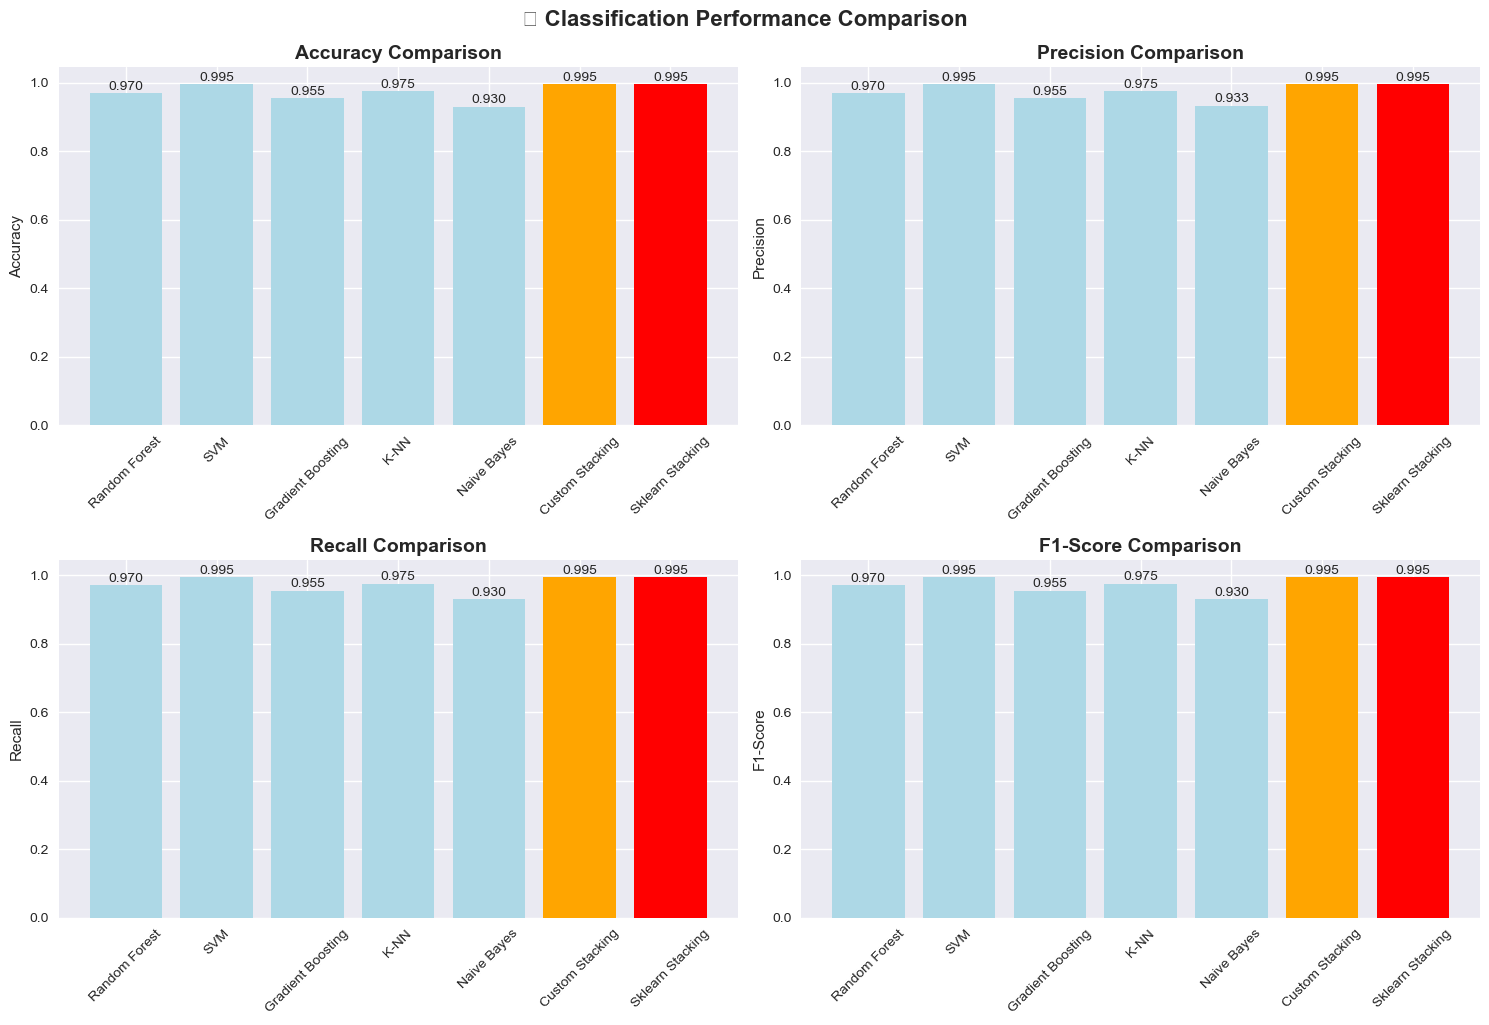


🏆 Best performing model: SVM


In [10]:
# Visualize results
results_df = pd.DataFrame(base_results).T
results_df.loc['Custom Stacking']  = [custom_acc, custom_prec, custom_rec, custom_f1]
results_df.loc['Sklearn Stacking'] = [sklearn_acc, sklearn_prec, sklearn_rec, sklearn_f1]

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics = ['accuracy', 'precision', 'recall', 'f1']
titles = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[i//2, i%2]
    
    # Highlight stacking methods
    colors = ['lightblue'] * len(base_models_clf) + ['orange', 'red']
    
    bars = ax.bar(results_df.index, results_df[metric], color=colors)
    ax.set_title(f'{title} Comparison', fontsize=14, fontweight='bold')
    ax.set_ylabel(title)
    ax.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.suptitle('🔍 Classification Performance Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.show()

print("\n🏆 Best performing model:", results_df['accuracy'].idxmax())

## **📈 6. Regression Example**

In [11]:
# Define base models for regression
base_models_reg = [
    ('Random Forest', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('SVR', SVR()),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42)),
    ('K-NN', KNeighborsRegressor()),
    ('Decision Tree', DecisionTreeRegressor(random_state=42))
]

# Meta-learner for regression
meta_model_reg = Ridge(random_state=42)

# Create and train custom stacking ensemble
print("🔧 Training Custom Stacking Regressor...")
start_time = time.time()

stacking_reg_custom = StackingEnsemble( base_models=base_models_reg, meta_model=meta_model_reg, cv=5, use_probabilities=False)

stacking_reg_custom.fit(X_train_reg_scaled, y_train_reg)
custom_reg_time = time.time() - start_time

print(f"⏱️ Custom implementation training time: {custom_reg_time:.2f} seconds")

🔧 Training Custom Stacking Regressor...
Training base model 1/5: Random Forest
Training base model 2/5: SVR
Training base model 3/5: Gradient Boosting
Training base model 4/5: K-NN
Training base model 5/5: Decision Tree
Training meta-learner...
⏱️ Custom implementation training time: 12.77 seconds


In [12]:
# Train sklearn StackingRegressor
print("🔧 Training Sklearn Stacking Regressor...")
start_time = time.time()

stacking_reg_sklearn = StackingRegressor( estimators=base_models_reg, final_estimator=Ridge(random_state=42), cv=5, n_jobs=-1)

stacking_reg_sklearn.fit(X_train_reg_scaled, y_train_reg)
sklearn_reg_time = time.time() - start_time

print(f"⏱️ Sklearn implementation training time: {sklearn_reg_time:.2f} seconds")

🔧 Training Sklearn Stacking Regressor...
⏱️ Sklearn implementation training time: 4.09 seconds


In [14]:
# Evaluate regression models
def evaluate_regression_model(model, X_test, y_test, model_name):
    """Evaluate regression model performance"""
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"📊 {model_name} Performance:")
    print(f"   MSE : {mse:.2f}")
    print(f"   RMSE: {rmse:.2f}")
    print(f"   MAE : {mae:.2f}")
    print(f"   R²  : {r2:.2f}\n")
    
    return mse, rmse, mae, r2

# Evaluate base models
base_reg_results = {}
for name, model in base_models_reg:
    model_clone = stacking_reg_custom._clone_model(model)
    model_clone.fit(X_train_reg_scaled, y_train_reg)
    mse, rmse, mae, r2 = evaluate_regression_model(model_clone, X_test_reg_scaled, y_test_reg, name)
    base_reg_results[name] = {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}

# Evaluate stacking models
custom_mse, custom_rmse, custom_mae, custom_r2 = evaluate_regression_model(stacking_reg_custom, X_test_reg_scaled, y_test_reg, "Custom Stacking")

sklearn_mse, sklearn_rmse, sklearn_mae, sklearn_r2 = evaluate_regression_model(stacking_reg_sklearn, X_test_reg_scaled, y_test_reg, "Sklearn Stacking")

📊 Random Forest Performance:
   MSE : 16207.08
   RMSE: 127.31
   MAE : 101.96
   R²  : 0.68

📊 SVR Performance:
   MSE : 47059.90
   RMSE: 216.93
   MAE : 175.99
   R²  : 0.08

📊 Gradient Boosting Performance:
   MSE : 8404.23
   RMSE: 91.67
   MAE : 70.99
   R²  : 0.84

📊 K-NN Performance:
   MSE : 21311.43
   RMSE: 145.98
   MAE : 117.87
   R²  : 0.58

📊 Decision Tree Performance:
   MSE : 35357.46
   RMSE: 188.04
   MAE : 151.28
   R²  : 0.31

📊 Custom Stacking Performance:
   MSE : 4664.05
   RMSE: 68.29
   MAE : 54.40
   R²  : 0.91

📊 Sklearn Stacking Performance:
   MSE : 4413.23
   RMSE: 66.43
   MAE : 52.61
   R²  : 0.91



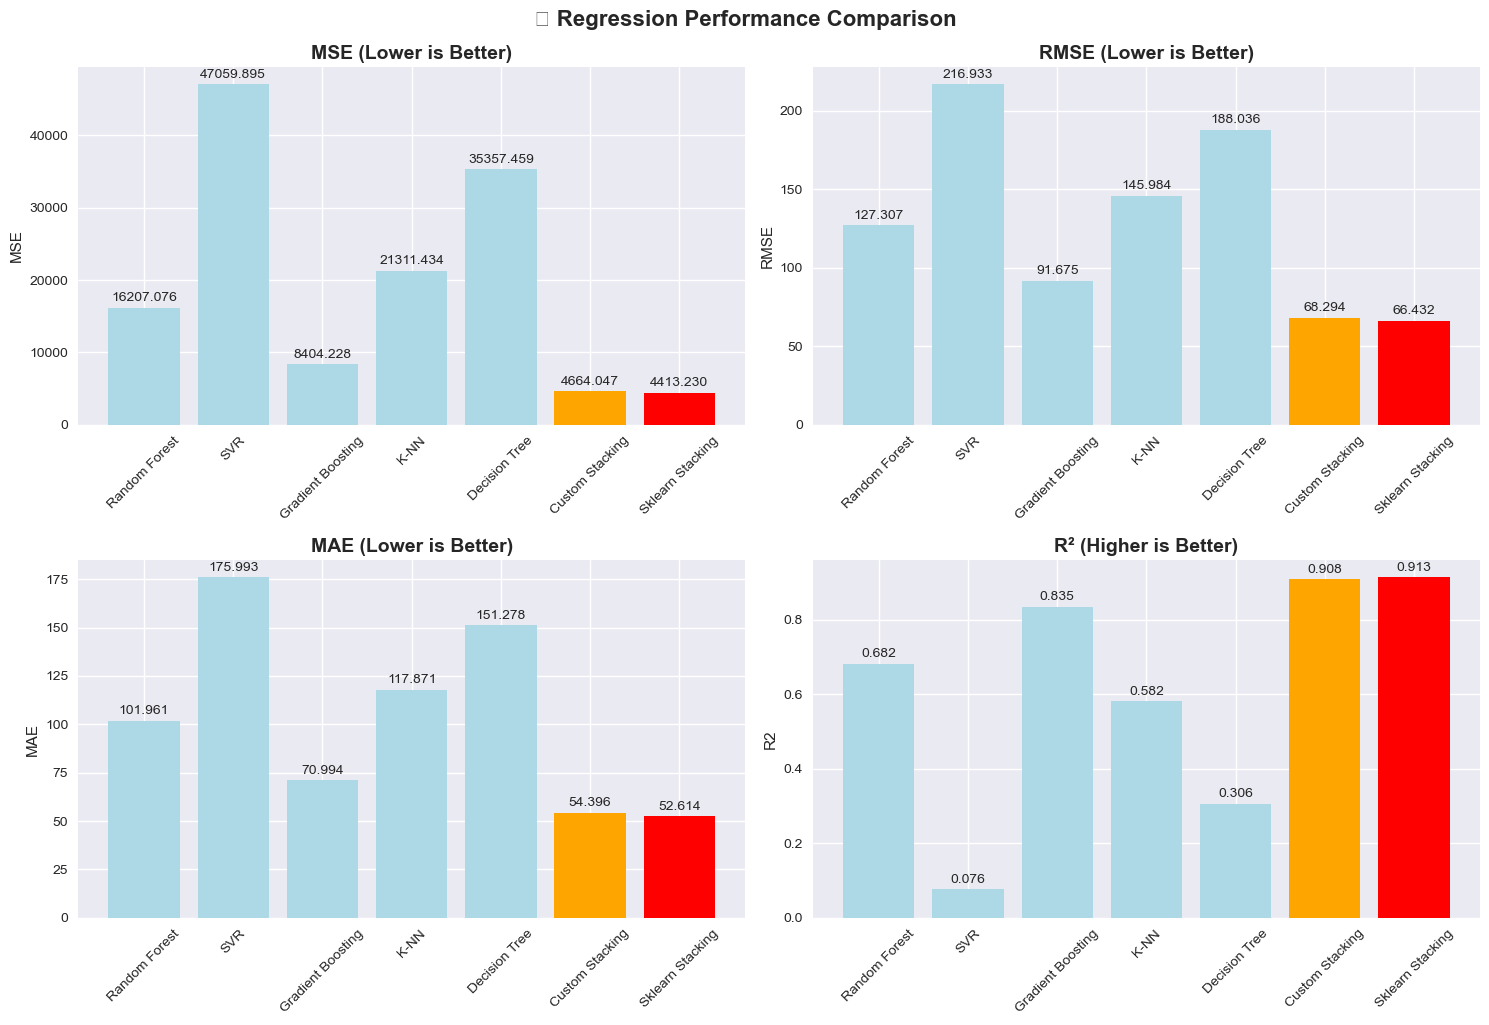


🏆 Best R² score: Sklearn Stacking (0.9134)
🏆 Lowest RMSE: Sklearn Stacking (66.4321)


In [15]:
# Visualize regression results
reg_results_df = pd.DataFrame(base_reg_results).T
reg_results_df.loc['Custom Stacking']  = [custom_mse, custom_rmse, custom_mae, custom_r2]
reg_results_df.loc['Sklearn Stacking'] = [sklearn_mse, sklearn_rmse, sklearn_mae, sklearn_r2]

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
reg_metrics = ['mse', 'rmse', 'mae', 'r2']
reg_titles = ['MSE (Lower is Better)', 'RMSE (Lower is Better)', 'MAE (Lower is Better)', 'R² (Higher is Better)']

for i, (metric, title) in enumerate(zip(reg_metrics, reg_titles)):
    ax = axes[i//2, i%2]
    
    colors = ['lightblue'] * len(base_models_reg) + ['orange', 'red']
    
    bars = ax.bar(reg_results_df.index, reg_results_df[metric], color=colors)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel(metric.upper())
    ax.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + max(reg_results_df[metric])*0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.suptitle('📈 Regression Performance Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.show()

print("\n🏆 Best R² score:", reg_results_df['r2'].idxmax(), f"({reg_results_df['r2'].max():.4f})")
print("🏆 Lowest RMSE:", reg_results_df['rmse'].idxmin(), f"({reg_results_df['rmse'].min():.4f})")

## **🔍 7. Real-World Dataset Example**

In [16]:
# Load breast cancer dataset
data = load_breast_cancer()
X_real, y_real = data.data, data.target

# Split and scale
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(X_real, y_real, test_size=0.2, random_state=42, stratify=y_real)

scaler_real = StandardScaler()
X_train_real_scaled = scaler_real.fit_transform(X_train_real)
X_test_real_scaled  = scaler_real.transform(X_test_real)

print(f"🏥 Breast Cancer Dataset:")
print(f"   Features : {X_real.shape[1]}")
print(f"   Samples  : {X_real.shape[0]}")
print(f"   Classes  : {len(np.unique(y_real))} (Malignant: {np.sum(y_real==1)}, Benign: {np.sum(y_real==0)})")

🏥 Breast Cancer Dataset:
   Features : 30
   Samples  : 569
   Classes  : 2 (Malignant: 357, Benign: 212)


In [18]:
# Train stacking on real dataset
stacking_real = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('svm', SVC(probability=True, random_state=42)),
        ('gb', GradientBoostingClassifier(random_state=42)),
        ('knn', KNeighborsClassifier()),
        ('nb', GaussianNB())
    ],
    final_estimator=LogisticRegression(random_state=42),
    cv=5,
    stack_method='predict_proba',
    n_jobs=-1
)

# Train and evaluate
stacking_real.fit(X_train_real_scaled, y_train_real)
y_pred_real  = stacking_real.predict(X_test_real_scaled)
y_proba_real = stacking_real.predict_proba(X_test_real_scaled)[:, 1]

# Calculate metrics
accuracy_real  = accuracy_score(y_test_real, y_pred_real)
precision_real = precision_score(y_test_real, y_pred_real)
recall_real    = recall_score(y_test_real, y_pred_real)
f1_real        = f1_score(y_test_real, y_pred_real)

# ROC curve
fpr, tpr, _ = roc_curve(y_test_real, y_proba_real)
roc_auc = auc(fpr, tpr)

print(f"🏥 Breast Cancer Stacking Results:")
print(f"   Accuracy:  {accuracy_real:.2f}")
print(f"   Precision: {precision_real:.2f}")
print(f"   Recall:    {recall_real:.2f}")
print(f"   F1-Score:  {f1_real:.2f}")
print(f"   ROC AUC:   {roc_auc:.2f}")

🏥 Breast Cancer Stacking Results:
   Accuracy:  0.96
   Precision: 0.96
   Recall:    0.97
   F1-Score:  0.97
   ROC AUC:   0.99


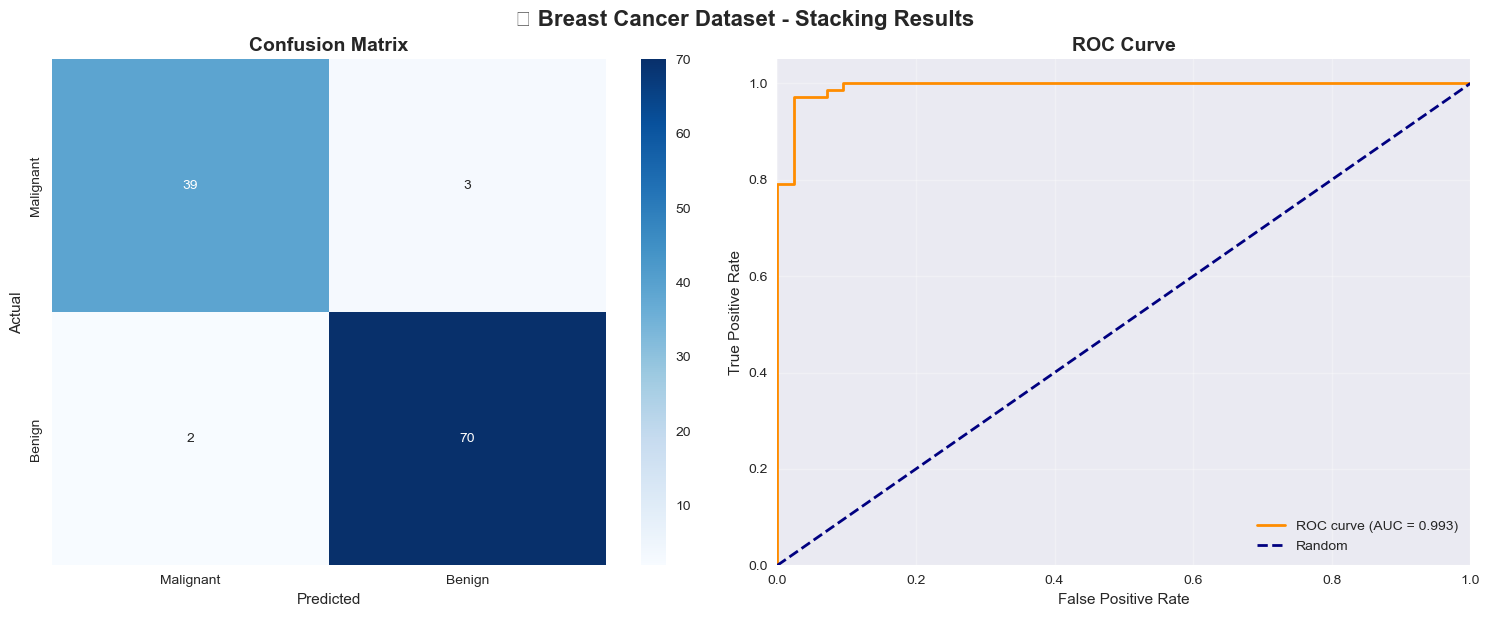

In [19]:
# Visualize real dataset results
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Confusion Matrix
cm = confusion_matrix(y_test_real, y_pred_real)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# ROC Curve
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[1].legend(loc="lower right")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('🏥 Breast Cancer Dataset - Stacking Results', fontsize=16, fontweight='bold', y=1.02)
plt.show()

## **⚙️ 8. Advanced Stacking Techniques**

### **8.1 Multi-Level Stacking**

In [20]:
# Multi-level stacking implementation
class MultiLevelStacking:
    """
    Multi-level stacking with multiple layers of meta-learners
    """
    
    def __init__(self, level_1_models, level_2_models, final_model, cv=5):
        self.level_1_models = level_1_models
        self.level_2_models = level_2_models
        self.final_model = final_model
        self.cv = cv
        
    def fit(self, X, y):
        # Level 1: Base models
        self.stacking_level_1 = StackingClassifier(
            estimators=self.level_1_models,
            final_estimator=LogisticRegression(random_state=42),
            cv=self.cv,
            stack_method='predict_proba'
        )
        
        # Level 2: Meta-models
        self.stacking_level_2 = StackingClassifier(
            estimators=self.level_2_models,
            final_estimator=self.final_model,
            cv=self.cv,
            stack_method='predict_proba'
        )
        
        # Train level 1
        self.stacking_level_1.fit(X, y)
        
        # Get level 1 predictions as features for level 2
        level_1_predictions = self.stacking_level_1.predict_proba(X)
        
        # Train level 2
        self.stacking_level_2.fit(level_1_predictions, y)
        
        return self
    
    def predict(self, X):
        level_1_predictions = self.stacking_level_1.predict_proba(X)
        return self.stacking_level_2.predict(level_1_predictions)
    
    def predict_proba(self, X):
        level_1_predictions = self.stacking_level_1.predict_proba(X)
        return self.stacking_level_2.predict_proba(level_1_predictions)

# Define models for each level
level_1_models = [
    ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),
    ('svm', SVC(probability=True, random_state=42)),
    ('knn', KNeighborsClassifier())
]

level_2_models = [
    ('gb', GradientBoostingClassifier(random_state=42)),
    ('nb', GaussianNB())
]

final_model = LogisticRegression(random_state=42)

# Train multi-level stacking
multi_stacking = MultiLevelStacking(level_1_models, level_2_models, final_model)
multi_stacking.fit(X_train_clf_scaled, y_train_clf)

# Evaluate
multi_pred = multi_stacking.predict(X_test_clf_scaled)
multi_acc = accuracy_score(y_test_clf, multi_pred)

print(f"🔥 Multi-Level Stacking Accuracy: {multi_acc:.4f}")

🔥 Multi-Level Stacking Accuracy: 0.9950


### **8.2 Feature Selection for Stacking**

In [21]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline

# Create pipelines with feature selection
base_models_with_fs = [
    ('rf_fs', Pipeline([
        ('selector', SelectKBest(f_classif, k=10)),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ])),
    ('svm_fs', Pipeline([
        ('selector', SelectKBest(f_classif, k=15)),
        ('classifier', SVC(probability=True, random_state=42))
    ])),
    ('gb_fs', Pipeline([
        ('selector', SelectKBest(f_classif, k=12)),
        ('classifier', GradientBoostingClassifier(random_state=42))
    ]))
]

# Stacking with feature selection
stacking_fs = StackingClassifier(
    estimators=base_models_with_fs,
    final_estimator=LogisticRegression(random_state=42),
    cv=5,
    stack_method='predict_proba'
)

stacking_fs.fit(X_train_clf_scaled, y_train_clf)
fs_pred = stacking_fs.predict(X_test_clf_scaled)
fs_acc = accuracy_score(y_test_clf, fs_pred)

print(f"🎯 Stacking with Feature Selection Accuracy: {fs_acc:.4f}")

🎯 Stacking with Feature Selection Accuracy: 0.9750


## **💡 9. Best Practices and Tips**

### **🎯 Stacking Best Practices:**

#### **1. Model Diversity**
- Use different algorithm types (tree-based, linear, instance-based)
- Vary hyperparameters significantly
- Include models with different strengths/weaknesses

#### **2. Cross-Validation Strategy**
- Use stratified K-fold for classification
- Ensure proper train/validation splits
- Consider time-based splits for time series

#### **3. Meta-Learner Selection**
- **Simple models**: Logistic Regression, Linear Regression
- **Avoid overfitting**: Regularized models work well
- **Feature scaling**: Important for meta-learner

#### **4. Computational Considerations**
- Stacking is computationally expensive
- Use parallel processing when possible
- Consider model complexity vs. improvement

#### **5. Overfitting Prevention**
- Proper cross-validation is crucial
- Don't use too many base models
- Validate on truly held-out test set

#### **6. When to Use Stacking**
- ✅ Large datasets with sufficient samples
- ✅ Competition settings where small improvements matter
- ✅ When you have diverse, well-performing base models
- ❌ Small datasets (risk of overfitting)
- ❌ When interpretability is crucial
- ❌ Real-time applications with strict latency requirements

## **📋 10. Summary and Key Takeaways**

### **🎓 What We Learned:**

1. **Stacking Concept**: Meta-learning approach that learns to combine predictions
2. **Implementation**: Both custom and scikit-learn implementations
3. **Cross-Validation**: Critical for preventing overfitting in meta-learner
4. **Model Diversity**: Key to stacking success
5. **Advanced Techniques**: Multi-level stacking, feature selection

### **🔑 Key Points:**

- **Stacking** learns optimal combination of models
- **Cross-validation** prevents information leakage
- **Meta-learner** should be simple to avoid overfitting
- **Diversity** in base models is crucial
- **Computational cost** is higher than simple ensembles

### **⚡ Quick Reference:**

```python
# Basic Stacking
from sklearn.ensemble import StackingClassifier

stacking = StackingClassifier(
    estimators=[('rf', RandomForestClassifier()), 
                ('svm', SVC(probability=True))],
    final_estimator=LogisticRegression(),
    cv=5
)
```

### **🌟 Next Steps:**
- Explore **Voting ensembles** for simpler combination strategies
- Learn about **Blending** as an alternative to stacking
- Study **AutoML** approaches that automate ensemble creation
- Practice with **Kaggle competitions** where stacking shines

---

<div style="text-align: center; padding: 20px; background-color:rgb(34, 40, 38); border-radius: 10px; margin: 20px 0;">
    <h3>🏗️ Congratulations! You've mastered Stacking! 🏗️</h3>
    <p><strong>You now understand how to build sophisticated ensemble models that learn to combine predictions optimally!</strong></p>
</div>